In [1]:
!pip install tensorflow shap numpy pandas matplotlib scikit-learn


Load Dataset

In [2]:
#Load Dataset
import pandas as pd
df = pd.read_csv("/content/time_series_dataset.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')
df.head()


,date,temperature,humidity,wind_speed,pressure,energy_consumption
0,2020-01-01,32.483571,51.710050,11.513977,1011.843367,14.795992
1,2020-01-02,29.308678,54.398190,8.155669,1008.033306,7.262875
2,2020-01-03,33.238443,67.472936,11.739212,1010.143724,10.708990
3,2020-01-04,37.615149,66.103703,12.711276,1016.392259,15.316591
4,2020-01-05,28.829233,59.790984,10.826870,1010.955495,9.567285


Feature Engineering(Lag Features)

In [3]:
# Target column
target = "energy_consumption"

# Lag features (1-day, 2-day, 3-day)
df["lag1"] = df[target].shift(1)
df["lag2"] = df[target].shift(2)
df["lag3"] = df[target].shift(3)

# Drop missing rows created by lagging
df = df.dropna()
df.head()


,date,temperature,humidity,wind_speed,pressure,energy_consumption,lag1,lag2,lag3
3,2020-01-04,37.615149,66.103703,12.711276,1016.392259,15.316591,10.708990,7.262875,14.795992
4,2020-01-05,28.829233,59.790984,10.826870,1010.955495,9.567285,15.316591,10.708990,7.262875
5,2020-01-06,28.829315,61.173274,13.753592,1010.232183,12.648169,9.567285,15.316591,10.708990
6,2020-01-07,37.896064,72.776649,8.452422,1003.200719,5.853960,12.648169,9.567285,15.316591
7,2020-01-08,33.837174,54.084286,7.510691,1013.731268,8.380328,5.853960,12.648169,9.567285


Select Features

In [4]:
features = ["temperature","humidity","wind_speed","pressure","lag1","lag2","lag3"]

X = df[features]
y = df[target]


Train/Test Split

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Reshape for LSTM → (samples, timesteps, features)
X_lstm = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])

X_train, X_test, y_train, y_test = train_test_split(
    X_lstm, y, test_size=0.2, shuffle=False
)


Build LSTM Model

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(64, activation="relu", return_sequences=False, input_shape=(1, len(features))))
model.add(Dense(32, activation="relu"))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mse")

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        18,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,545 (80.25 KB)

 Trainable params: 20,545 (80.25 KB)

 Non-trainable params: 0 (0.00 B)

Train Model

In [7]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.1)


Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 107.1504 - val_loss: 140.8968
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 100.0364 - val_loss: 139.4989
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 106.5838 - val_loss: 137.6250
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 100.4004 - val_loss: 135.0926
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 103.3922 - val_loss: 131.7497
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 93.9547 - val_loss: 127.4445
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 90.7371 - val_loss: 121.9148
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 89.8405 - val_loss: 114.9498
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 87.3986 - val_loss: 106.4090
Epoch 10/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 79.4030 - val_loss: 96.3160
Epoch 11/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 70.2426 - val_loss: 84.8589
Epoch 12/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

Predictions

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


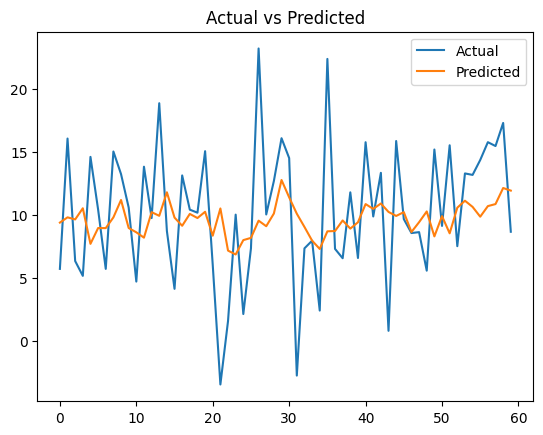

In [8]:
import matplotlib.pyplot as plt

y_pred = model.predict(X_test)

plt.plot(y_test.values, label="Actual")
plt.plot(y_pred, label="Predicted")
plt.legend()
plt.title("Actual vs Predicted")
plt.show()


Prepare Data for SHAP

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


  0%|          | 0/50 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
197/197 ━━━━━━

/tmp/ipython-input-3268537919.py:23: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test_2D[:50], feature_names=features)


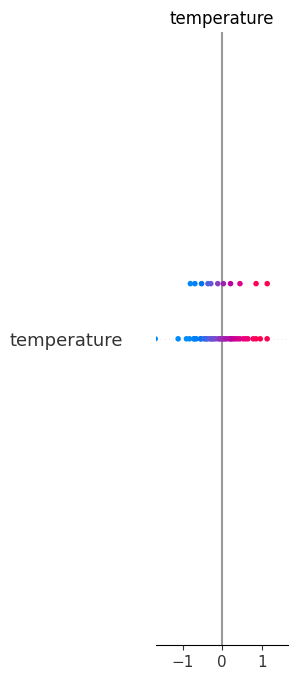

In [15]:
import shap
import numpy as np

# 1) Convert test data into 2D (SHAP requirement)
X_train_2D = X_train.reshape(X_train.shape[0], X_train.shape[2])
X_test_2D = X_test.reshape(X_test.shape[0], X_test.shape[2])

# 2) Function for prediction required by SHAP
def lstm_predict(x):
    x_reshaped = x.reshape(x.shape[0], 1, x.shape[1])   # convert back to 3D
    return model.predict(x_reshaped)

# 3) Select background data (SHAP requirement)
background = X_train_2D[np.random.choice(X_train_2D.shape[0], 50, replace=False)]

# 4) Create SHAP KernelExplainer
explainer = shap.KernelExplainer(lstm_predict, background)

# 5) Compute SHAP values for test data
shap_values = explainer.shap_values(X_test_2D[:50])   # use first 50 for speed

# 6) Summary plot
shap.summary_plot(shap_values, X_test_2D[:50], feature_names=features)



In [35]:
shap.initjs()

i = 0

shap.force_plot(
    explainer.expected_value,shap_values[i, :, 0],
    X_test_2D[i],
    feature_names=features
)
